# Imports

In [91]:
import random
import matplotlib.pyplot as plt
from scipy import stats

# Define model class

In [92]:
class Model():

    def __init__(self, num_of_agents=10, num_iterations=10, mode ='homogeneous'):
        self.agent_types = ['low', 'moderate', 'high'] 
        self.num_iterations = num_iterations
        self.mode = mode

        #creating lists
        self.num_infected_per_iteration = []
        self.num_low_sus_per_iteration = []
        self.num_mod_sus_per_iteration = []
        self.num_high_sus_per_iteration = []
        
        self.num_of_panicked = 0
        self.panicked_agents = list()

        #model time
        self.time = 0
        
        #create the agents, random.choice allocates agents to a type 
        self.agents = []
        for i in range(num_of_agents):
            # adding each new created agent to a list
            if self.mode == 'homogeneous' or self.mode == 'heterogeneous':
                self.agents.append(Agent(self))
            if self.mode == 'adv_heterogeneous':
                self.agents.append(Agent(self, agent_types=random.choice(self.agent_types)))
    
        
        # if the model hasn't finished running yet
        self.model_finished = False 
    
    def run(self):
        for t in range(self.num_iterations):
            for agent in self.agents: # every agent, in every iteration, moves forward
                agent.step()
            for i, agent in enumerate(self.agents):
#                     print('Agent {0}/{1}:'.format(i, self.num_of_agents))    
#                 if self.mode == 'homogeneous':
#                     print('my likelihood:{}, my state:{}'.format(agent.likelihood_homogeneous, agent.state))
                    if self.mode == 'heterogeneous':
                        print('my likelihood:{}, my state:{}'.format(agent.likelihood, agent.state))
            
            self.num_infected_per_iteration.append(self.get_num_infected())
            self.num_low_sus_per_iteration.append(self.get_num_low_sus())
            self.num_mod_sus_per_iteration.append(self.get_num_mod_sus())
            self.num_high_sus_per_iteration.append(self.get_num_high_sus())
        
            if self.mode == 'homogeneous' or self.mode == 'heterogeneous':
                print('step: {},  total infected:{}'.format(t,self.get_num_infected()))
            if self.mode == 'adv_heterogeneous':
                 print('step: {}, low:{}, mod:{}, high:{}'.format(t, self.get_num_low_sus(), self.get_num_mod_sus(), self.get_num_high_sus()))
    
        #step time
        self.time += 1
        
        #once each iteration is done, model is finished
        self.model_finished = True 
        
        #creating a list of panicked agents, appending new ones after each new step                   
        panicked_agents = list()
        
        for agent in self.agents:
            if agent.state == 1:
                panicked_agents.append(agent)
        self.num_of_panicked = len(panicked_agents)
        self.panicked_agents.append(self.num_of_panicked)
        
    def get_num_infected(self):
        #gets number of agents that are infected
        return len([ a for a in self.agents if a.state==1 ]) 

    def get_num_low_sus(self):
        return len([ a for a in self.agents if a.state==0 and a.agent_types=='low' ]) 
    
    def get_num_mod_sus(self):
        return len([ a for a in self.agents if a.state==0 and a.agent_types=='moderate' ]) 
    
    def get_num_high_sus(self):
        return len([ a for a in self.agents if a.state==0 and a.agent_types=='high' ]) 
        
        
    def graph_num_infected(self):
        """
        Uses matplotlib to create a graph
        """
        if not self.model_finished:
            print("Can't print the number of infected until the model has finished")
            return
        
        # Create a figure and an axis (if you want more than one plot in the same
        # figure you can adjust the subplots function)
        
        fig, ax = plt.subplots(num=None, figsize=(5, 3), dpi=128, facecolor='w', edgecolor='k')
        
        # Do a scatter plot
        if self.mode == 'homogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_infected_per_iteration], "o-",
                    c="red", label=" Total infected") 
            
        if self.mode == 'heterogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_infected_per_iteration], "o-",
                    c="red", label=" Total infected") 
            
        if self.mode == 'adv_heterogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_low_sus_per_iteration], "o-",
                    c="green", label="No. Low Sus")
        
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_mod_sus_per_iteration], "o-",
                    c="orange", label="No. Mod Sus")
                
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_high_sus_per_iteration], "o-",
                    c="blue", label="No. High Sus")
        
        ax.set_title("Number of infected per iteration")
        ax.set_ylim(0,len(self.agents)) # limit the y axis
        ax.set_xlabel("Iteration (time)")
        ax.set_ylabel("Number of infected")
        ax.legend(loc='upper left')
        
        #plt.savefig("benchmark-agents_vs_error.png", bbox_inches="tight")

## Defining agent class

In [93]:
class Agent():
    
    #All agents, are assigned an alpha, beta and gamma. 
    #Agents in the heterogenous populations are assigned with a moderate agent type. 
    def __init__(self, model, alpha = 0.5, beta = 0.1, gamma= 0.1, agent_types = 'moderate'):
        
        self.agent_types = agent_types
        #Agents all start out susceptible,
        #when agents state = 1 they are infected
        self.state = 0
        #rate of spontaneous infection
        self.alpha = alpha
        #recovery rate
        self.gamma = gamma
        #rate of infection
        self.Beta = beta 
        #to capture each agents likelihood
        self.likelihood = 0
        
        #creating lists for each population
        self.likelihood_homogeneous = list()
        self.likelihood_heterogeneous_one = list()
        self.likelihood_heterogeneous_two = list()
        
        #pointer to the model class
        self.model = model
        
        #For the simple heterogenous simulation, 
        #agents draw betas from normal distribution
        if model.mode == ['heterogeneous']:
            self.Beta = self.heterogeneous_model_one_beta

        
        #For the advanced heterogeneous sim, agents are allocated into a 
        #class of susceptibility, according to their agent type
        self.beta_low = self.low_sus()
        self.beta_mod = self.moderate_sus()
        self.beta_high = self.high_sus()

        r = random.random()
        
        #creating a list of all susceptibility classes.
        self.susceptibility = (self.low_sus, self.moderate_sus, self.high_sus) 
        
        if model.mode == ['adv_heterogenous']:
            if self.state == 0: 
                if random.random() <0.5:
                    self.susceptibility = self.low_sus()
                elif random.random() == 0.5:
                    self.susceptibility = self.moderate_sus()
                else:
                    self.susceptibility = self.high_sus()
       
    #Here, we create the different beta functions for the heterogeneous simulations. 
    def low_sus(self):
        return stats.norm.rvs(loc = 0.2, scale = 0.2)
        
    def moderate_sus(self):
        return stats.norm.rvs(loc = 0.4, scale = 0.2)
        
    def high_sus(self):
        return stats.norm.rvs(loc = 0.6, scale = 0.2)

    def heterogeneous_model_one_beta(self):
        return stats.norm.rvs(loc = 0, scale = 1)
    
    #Every time the heterogeneous simulations are ran, we update the betas 
    def update_beta(self):
        self.beta_low = self.low_sus()
        self.beta_mod = self.moderate_sus()
        self.beta_high = self.high_sus()
        
    def prob(self):
        return stats.norm.rvs(loc = 0, scale = 1) 
    
    
    #In each simulation and each time step, every susceptible agent has a probability of 50% of becoming panicked. 
    #If agents are already panicked, they have a probability of 50% of recovering. 
    def step(self):
        if self.state == 0:
            if self.prob()>0.5:
                self.homogeneous_model()
                if model.mode == ['heterogeneous']:
                    self.heterogeneous_model_one()
#                 if model.mode ==['adv_heterogeneous']:
#                     self.heterogeneous_model_two()
                
        else:
            self.recover()
            # print(self.state)
            
    #For the homogeneous model, agents compute their likelihood and then, depending on some probability can become infected. 
    def homogeneous_model(self):
        num_infected = model.get_num_infected()
        
        self.likelihood_homogeneous = list()
        
        if model.mode == ['homogeneous']:
            self.likelihood = self.alpha + (num_infected * self.Beta)
            
            if r < self.likelihood: 
                self.state = 1
#             else:
#                 self.other_agents()
                
            self.likelihood_homogeneous.append(self.likelihood)
            
    #In the simple heterogeneous function, the only difference is that the agents draw their betas randomly from the same normal distribution.        
    def heterogeneous_model_one(self):
        num_infected = model.get_num_infected()
        
        self.likelihood_heterogeneous_one = list()
        
        if model.mode == ['heterogeneous']:
            self.likelihood = self.alpha + (num_infected * self.heterogeneous_model_one_beta)
            
            if r < self.likelihood: 
                self.state = 1
            else:
                self.other_agents()
                
            self.likelihood_heterogeneous_one.append(self.likelihood)
    
    #In the advanced heterogeneous function, agents draw betas randomly from different distrubitions, according to their agent type and susceptibility        
    def heterogeneous_model_two(self):
        num_infected = model.get_num_infected()
        
        self.update_beta()
        
        r = random.random()
        
        self.likelihood_heterogeneous_two = list()
        
        if model.mode == ['adv_heterogeneous']: 
            self.likelihood_low_sus = self.alpha + (num_infected * self.beta_low)
            self.likelihood_moderate_sus = self.alpha + (num_infected* self.beta_mod)
            self.likelihood_high_sus = self.alpha + (num_infected * self.beta_high)
            
            if self.agent_types == 'low':
                if r < self.likelihood_low_sus:
                    self.state = 1
            elif self.agent_types == 'moderate':
                if r < self.likelihood_moderate_sus:
                    self.state = 1
            else: 
                self.agent_types =='high'  
                if r < self.likelihood_high_sus:
                    self.state = 1    
    
            self.likelihoods_low.append(self.likelihood_low_sus)
            self.likelihoods_mod.append(self.likelihood_moderate_sus)
            self.likelihoods_high.append(self.likelihood_high_sus)
            
    #Agents can observe the state of other agents in the previous timestep, and be pressured into becoming panicked.        
    def other_agents(self):
        if model.num_of_panicked > model.num_of_agents * 0.5:
            self.state = 1
            print("I became panicked after seeing others panic")
            
    #In this function, agents recover from panicked to suspectible
    #Agents in the heterogeneous models recover and are more likely to get re-allocated into a lower susceptibility class.         
    def recover(self):
        r1 = random.random()
        if r1 < self.gamma:
            self.state = 0
            if r1 > 0.8:
                self.agent_types == 'low' or self.agent_types == 'moderate'
            
            else:
                self.agent_types =='high'
    

## Running model

step: 0,  total infected:0
step: 1,  total infected:0
step: 2,  total infected:0
step: 3,  total infected:0
step: 4,  total infected:0
step: 5,  total infected:0
step: 6,  total infected:0
step: 7,  total infected:0
step: 8,  total infected:0
step: 9,  total infected:0


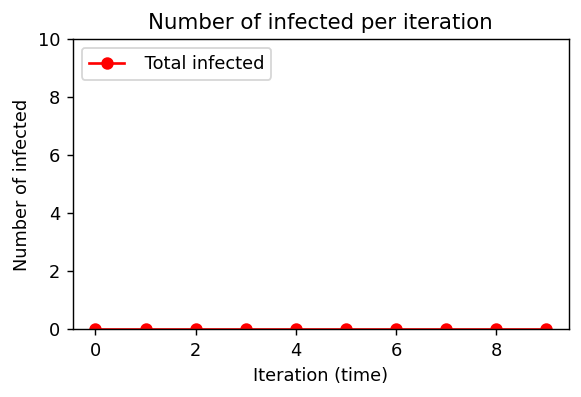

In [94]:
model = Model(num_of_agents=10, num_iterations=10, mode = 'homogeneous')
model.run()
model.graph_num_infected()